# **Notebook 2a**: YOLOv11

<span style="font-size: 1.5rem;">By **Michael Farrugia**</span>

## Section 0: Notebook Metadata and Configuration

Student: Michael Farrugia  
Course: ARI3129 - Advanced Computer Vision for AI  
Task: 2a - Object Detection (Sign Type)  
Architecture: YOLOv11  
Framework: PyTorch

### Reproducibility
- Fixed seed: 3129
- Deterministic: torch.backends.cudnn.deterministic = True
- Minimal augmentation (photometric only, no geometric transforms)

In [26]:
# Configuration Constants
SEED = 3129
NUM_CLASSES = 6
EPOCHS = 8
BATCH_SIZE = 8
LEARNING_RATE = 0.01  # Increased from 0.005 for better YOLO training
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
IMAGE_SIZE = 640  # YOLO standard
PATIENCE = 20  # Early stopping patience
WORKERS = 0  # Windows compatibility

# Paths
DATA_ROOT = "dataset/YOLO_COCO"
TRAIN_ANN = f"{DATA_ROOT}/labels/train.txt" # Not used by YOLO directly in this form usually, but good for checking
VAL_ANN = f"{DATA_ROOT}/labels/val.txt"
TEST_ANN = f"{DATA_ROOT}/labels/test.txt"
TRAIN_IMG = f"{DATA_ROOT}/images/train"
VAL_IMG = f"{DATA_ROOT}/images/val"
TEST_IMG = f"{DATA_ROOT}/images/test"
OUTPUT_DIR = "work_dirs/yolov11_sign_type"
YAML_PATH = f"{OUTPUT_DIR}/data.yaml"

# Class names
CLASS_NAMES = [
    "Blind-Spot Mirror (Convex)",
    "No Entry (One Way)",
    "No Through Road (T-Sign)",
    "Pedestrian Crossing",
    "Roundabout Ahead",
    "Stop"
]

# Color map for visualizations
COLOR_MAP = {
    "Stop": (53, 57, 229),                 # #E53935
    "No Entry (One Way)": (170, 36, 142),   # #8E24AA
    "Pedestrian Crossing": (229, 136, 30),  # #1E88E5
    "Roundabout Ahead": (71, 160, 67),      # #43A047
    "No Through Road (T-Sign)": (53, 216, 253),  # #FDD835
    "Blind-Spot Mirror (Convex)": (0, 140, 251)  # #FB8C00
}

## Section 1: Environment Setup (PyTorch + Logging)

This section imports required libraries, prints environment information, and sets up reproducibility.

In [16]:
import torch
import torchvision
from torchvision import transforms as T
import torch.utils.data
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import os
import time
import random
import yaml
from pathlib import Path
from ultralytics import YOLO

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [17]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Print environment info
print("ENVIRONMENT INFORMATION")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
print(f"\nRandom seed set to: {SEED}")

# Verify reproducibility setup
print("Reproducibility Configuration:")
print(f"  Seed: {SEED}")
print(f"  CUDNN Deterministic: True")
print(f"  CUDNN Benchmark: False")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"\nOutput directory: {OUTPUT_DIR}")

ENVIRONMENT INFORMATION
PyTorch version: 2.8.0+cu128
Torchvision version: 0.23.0+cpu
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 4070
GPU memory: 12.88 GB
Using device: cuda

Random seed set to: 3129
Reproducibility Configuration:
  Seed: 3129
  CUDNN Deterministic: True
  CUDNN Benchmark: False

Output directory: work_dirs/yolov11_sign_type


## Section 2: Dataset Validation

This section validates dataset paths, loads COCO annotations, builds category ID mappings, and visualizes ground truth samples.

In [18]:
print("DATASET VALIDATION & PREPARATION")

# 1. Validate paths exist
paths_to_check = [
    (TRAIN_IMG, "Train images"),
    (VAL_IMG, "Val images"),
    (TEST_IMG, "Test images")
]

all_exist = True
for path, desc in paths_to_check:
    exists = os.path.exists(path)
    status = "OK" if exists else "MISSING"
    print(f"{status} {desc}: {path}")
    if not exists:
        all_exist = False

if not all_exist:
    raise FileNotFoundError("Some dataset paths are missing!")

print("\nAll image paths validated successfully")

# 2. Create YOLO configuration file
data_yaml = {
    'path': os.path.abspath(DATA_ROOT),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {i: name for i, name in enumerate(CLASS_NAMES)}
}

print(f"\nCreating YOLO configuration at {YAML_PATH}...")
with open(YAML_PATH, 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)

with open(YAML_PATH, 'r') as f:
    print(f.read())
print("YAML configuration created.")

# 3. Count dataset sizes
train_images = len([f for f in os.listdir(TRAIN_IMG) if f.endswith(('.jpg', '.png'))])
val_images = len([f for f in os.listdir(VAL_IMG) if f.endswith(('.jpg', '.png'))])
test_images = len([f for f in os.listdir(TEST_IMG) if f.endswith(('.jpg', '.png'))])

print("\nDATASET STATISTICS")
print(f"Train: {train_images} images")
print(f"Val: {val_images} images")
print(f"Test: {test_images} images")

# 4. Category mapping
print("\nCATEGORY MAPPING")
print("Class ID -> Name")
for i, name in enumerate(CLASS_NAMES):
    print(f"  {i} -> {name}")

DATASET VALIDATION & PREPARATION
OK Train images: dataset/YOLO_COCO/images/train
OK Val images: dataset/YOLO_COCO/images/val
OK Test images: dataset/YOLO_COCO/images/test

All image paths validated successfully

Creating YOLO configuration at work_dirs/yolov11_sign_type/data.yaml...
path: c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision
  for Artificial Intelligence\Assignment_LATEST\dataset\YOLO_COCO
train: images/train
val: images/val
test: images/test
names:
  0: Blind-Spot Mirror (Convex)
  1: No Entry (One Way)
  2: No Through Road (T-Sign)
  3: Pedestrian Crossing
  4: Roundabout Ahead
  5: Stop

YAML configuration created.

DATASET STATISTICS
Train: 253 images
Val: 47 images
Test: 45 images

CATEGORY MAPPING
Class ID -> Name
  0 -> Blind-Spot Mirror (Convex)
  1 -> No Entry (One Way)
  2 -> No Through Road (T-Sign)
  3 -> Pedestrian Crossing
  4 -> Roundabout Ahead
  5 -> Stop



Visualizing 2 ground truth samples:


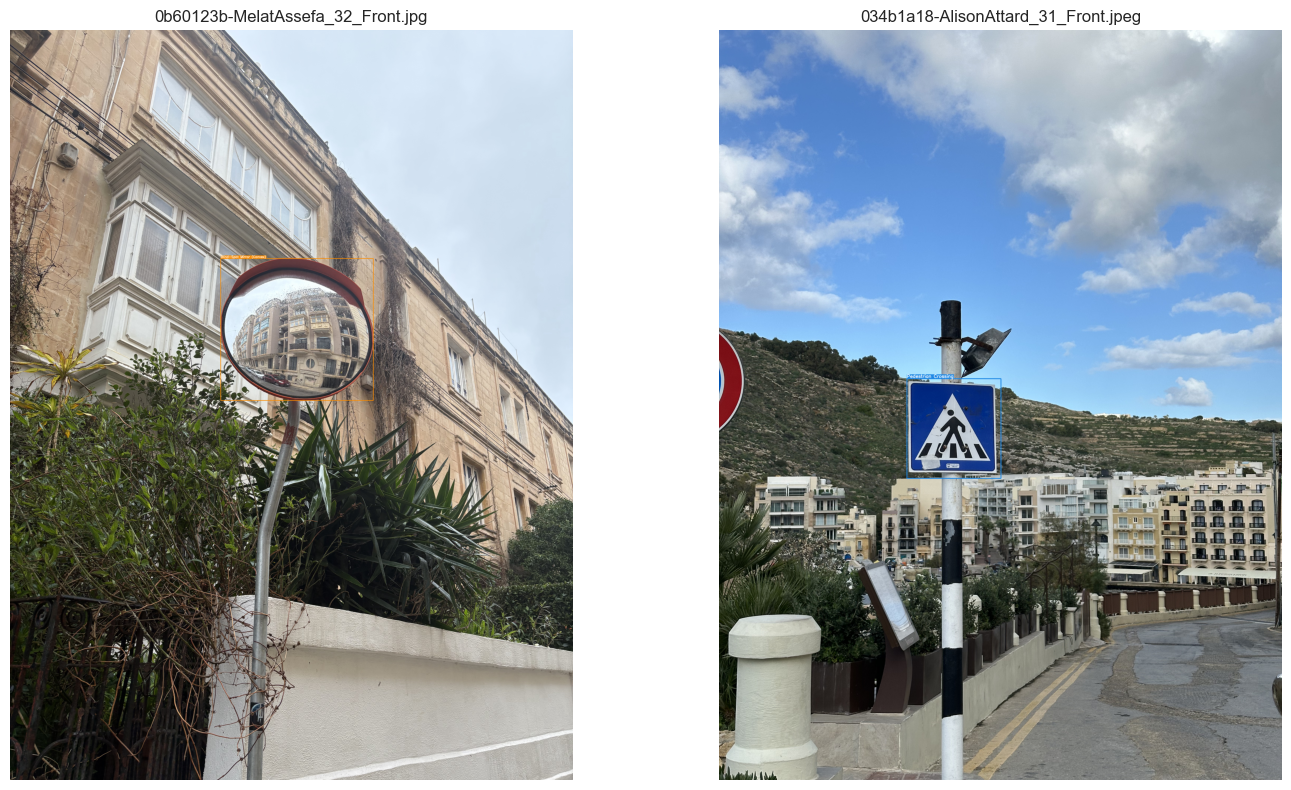

In [19]:
# Visualize ground truth samples (YOLO format)
def visualize_yolo_samples(image_dir, label_dir, class_names, num_samples=2):
    print(f"\nVisualizing {num_samples} ground truth samples:")
    
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_files = random.sample(image_files, num_samples)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 8))
    if num_samples == 1:
        axes = [axes]
        
    for idx, img_file in enumerate(sample_files):
        img_path = os.path.join(image_dir, img_file)
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = os.path.join(label_dir, label_file)
        
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        h_img, w_img = img.shape[:2]
        
        # Read labels
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                
                cls_id = int(parts[0])
                cx, cy, w, h = map(float, parts[1:5])
                
                # De-normalize
                width = w * w_img
                height = h * h_img
                x_center = cx * w_img
                y_center = cy * h_img
                
                x1 = int(x_center - width/2)
                y1 = int(y_center - height/2)
                x2 = int(x_center + width/2)
                y2 = int(y_center + height/2)
                
                cat_name = class_names[cls_id] if 0 <= cls_id < len(class_names) else str(cls_id)
                color = COLOR_MAP.get(cat_name, (0, 255, 0))
                
                # Draw box
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
                
                # Draw label
                text = cat_name
                (text_w, text_h), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                cv2.rectangle(img, (x1, y1 - text_h - 5), (x1 + text_w, y1), color, -1)
                cv2.putText(img, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(img_file)
        axes[idx].axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualize
random.seed(SEED)
TRAIN_LABEL_DIR = os.path.join(DATA_ROOT, "labels", "train")
visualize_yolo_samples(TRAIN_IMG, TRAIN_LABEL_DIR, CLASS_NAMES, num_samples=2)

## Section 3: Model Setup and Configuration

This section initializes the YOLOv11 model. We use the 'n' (nano) variant for speed, but 's', 'm', 'l', 'x' are also available.
Training from pretrained weights (`yolo11n.pt`) is recommended.


In [20]:
print("MODEL CONFIGURATION")

# Load model
# Use 'yolo11n.pt' for transfer learning. 
# Ultralytics handles class number adaptation automatically when training starts with a new data.yaml.
model_name = "yolo11n.pt"  
print(f"Loading model: {model_name}")

model = YOLO(model_name)

# Display model info
print("\nModel Architecture:")
model.info()

print("\nModel Configuration Summary:")
print(f"  Architecture: YOLOv11 Nano")
print(f"  Pretrained: COCO (80 classes)")
print(f"  Fine-tuning for: {NUM_CLASSES} classes")
print(f"  Optimizer: SGD")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Momentum: {MOMENTUM}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Image size: {IMAGE_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Device: {device}")

MODEL CONFIGURATION
Loading model: yolo11n.pt

Model Architecture:
YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs

Model Configuration Summary:
  Architecture: YOLOv11 Nano
  Pretrained: COCO (80 classes)
  Fine-tuning for: 6 classes
  Optimizer: SGD
  Learning rate: 0.01
  Momentum: 0.9
  Weight decay: 0.0005
  Batch size: 8
  Image size: 640
  Epochs: 8
  Device: cuda


## Section 4: Training

We train the model using the Ultralytics API. This uses the `data.yaml` we created earlier.
Results (weights, plots, logs) will be saved to `work_dirs/yolov11_sign_type`.


In [ ]:
print("TRAINING STARTED")
print()

torch.cuda.empty_cache()

training_start_time = time.time()

# Create absolute path to avoid Ultralytics prepending "runs/detect/"
import os
abs_output_dir = os.path.abspath(OUTPUT_DIR)

results = model.train(
    data=YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    lr0=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    optimizer='SGD',
    device='cuda' if torch.cuda.is_available() else 'cpu',
    project=abs_output_dir,  # Use absolute path to prevent "runs/detect/" prefix
    name='',  # Empty name to avoid extra nesting
    exist_ok=True,
    seed=SEED,
    deterministic=True,
    plots=True,
    val=True,
    workers=WORKERS,
    patience=PATIENCE,
    save=True,
    amp=False,  # Disable AMP for stability
    verbose=True,
    cos_lr=True,  # Cosine LR scheduler
    close_mosaic=10  # Disable mosaic in last 10 epochs
)

training_time = time.time() - training_start_time

print()
print("TRAINING COMPLETED")
print(f"Total time: {training_time/3600:.2f} hours")
print(f"Results saved to: {OUTPUT_DIR}")

TRAINING STARTED

Ultralytics 8.4.9  Python-3.11.14 torch-2.8.0+cu128 CPU (13th Gen Intel Core i5-13600KF)
engine\trainer: agnostic_nms=False, amp=False, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=work_dirs/yolov11_sign_type/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=8, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.9, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, 

## Section 5: Test Set Evaluation

This section evaluates the trained model on the held-out test set using YOLO metrics.

TEST SET EVALUATION

Loaded best checkpoint from work_dirs/yolov11_sign_type/train/weights/best.pt
Ultralytics 8.4.9  Python-3.11.14 torch-2.8.0+cu128 CPU (13th Gen Intel Core i5-13600KF)
YOLO11n summary (fused): 101 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 3058.3361.0 MB/s, size: 5374.1 KB)
val: Scanning C:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\YOLO_COCO\labels\test.cache... 86 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 86/86  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 1.3it/s 8.8s0.8s
                   all         86         93      0.803      0.903      0.912      0.811
Blind-Spot Mirror (Convex)         17         17      0.944       0.99      0.986      0.796
    No Entry (One Way)         36         37      0.839      0.865      0.849      0.741
N

C:\Users\micha\AppData\Local\Temp\ipykernel_25208\1297456557.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(per_class_ap.values()), y=list(per_class_ap.keys()), palette='viridis')


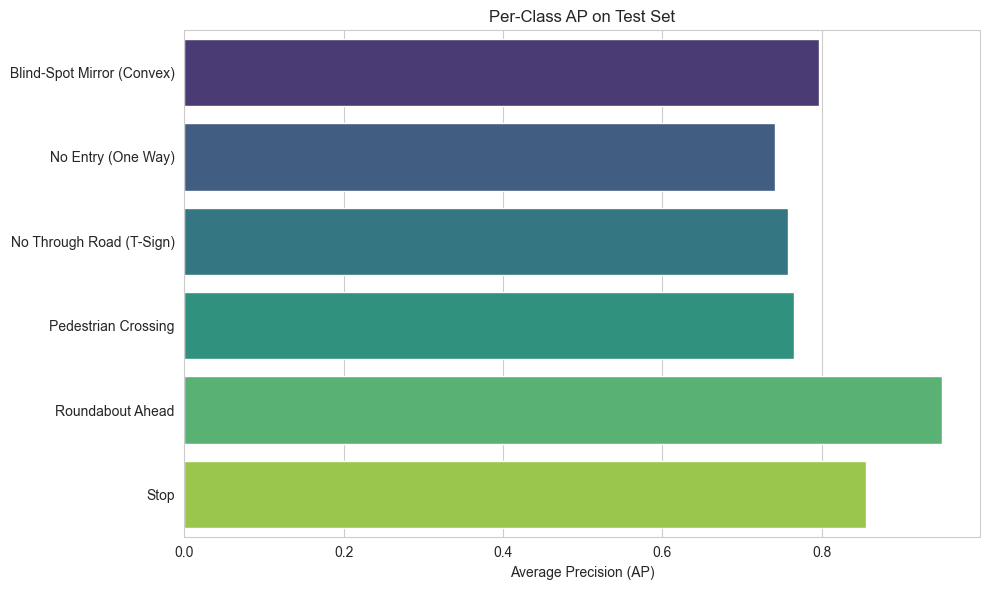

Per-class AP chart saved



In [ ]:
print("TEST SET EVALUATION")
print()

# Load best model from work_dirs (now using cleaner structure)
best_model = YOLO(f"{OUTPUT_DIR}/train/weights/best.pt")
print(f"Loaded best checkpoint from {OUTPUT_DIR}/train/weights/best.pt")

# Evaluate on test set
test_metrics = best_model.val(
    data=YAML_PATH,
    split='test',
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    plots=True,
    save_json=True,
    verbose=True
)

# Extract and display metrics
print()
print("OVERALL TEST METRICS")
print(f"mAP@0.5:0.95: {test_metrics.box.map:.4f}")
print(f"mAP@0.5: {test_metrics.box.map50:.4f}")
print(f"mAP@0.75: {test_metrics.box.map75:.4f}")
print()

# Per-class AP
print("PER-CLASS AP")
if hasattr(test_metrics.box, 'maps'):
    per_class_ap = {}
    for idx, class_name in enumerate(CLASS_NAMES):
        if idx < len(test_metrics.box.maps):
            ap_value = test_metrics.box.maps[idx]
            per_class_ap[class_name] = ap_value
            print(f"{class_name}: {ap_value:.4f}")
        else:
            per_class_ap[class_name] = 0.0
            print(f"{class_name}: 0.0000")
else:
    per_class_ap = {name: test_metrics.box.map for name in CLASS_NAMES}
    for name in CLASS_NAMES:
        print(f"{name}: {test_metrics.box.map:.4f}")

print()

# Per-class AP bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(per_class_ap.values()), y=list(per_class_ap.keys()), palette='viridis')
plt.xlabel('Average Precision (AP)')
plt.title('Per-Class AP on Test Set')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/per_class_ap.png", dpi=150)
plt.show()
print("Per-class AP chart saved")
print()

## Section 6: Training Curves and Monitoring

This section visualizes training dynamics through YOLOv11 training logs.

In [30]:
print("TRAINING CURVES")
print()

# Load training results CSV
results_csv = f"{OUTPUT_DIR}/results.csv"

if os.path.exists(results_csv):
    train_results_df = pd.read_csv(results_csv)
    train_results_df.columns = train_results_df.columns.str.strip()
    
    # Create custom training curves matching Faster R-CNN style
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = train_results_df.index + 1
    
    # Total loss
    if 'train/box_loss' in train_results_df.columns:
        total_loss = (train_results_df['train/box_loss'] + 
                     train_results_df.get('train/cls_loss', 0) + 
                     train_results_df.get('train/dfl_loss', 0))
        ax1.plot(epochs, total_loss, marker='o', linewidth=2, markersize=5, label='Total Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss (Total)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Component losses
    if 'train/box_loss' in train_results_df.columns and 'train/cls_loss' in train_results_df.columns:
        ax2.plot(epochs, train_results_df['train/box_loss'], 
                marker='s', linewidth=2, markersize=5, label='Box Loss')
        ax2.plot(epochs, train_results_df['train/cls_loss'], 
                marker='^', linewidth=2, markersize=5, label='Cls Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title('Training Loss (Components)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Validation mAP
    if 'metrics/mAP50(B)' in train_results_df.columns:
        val_map = train_results_df['metrics/mAP50(B)']
        best_epoch = val_map.idxmax() + 1
        ax3.plot(epochs, val_map, marker='o', linewidth=2, markersize=6, 
                color='green', label='Val mAP@0.5')
        ax3.axvline(x=best_epoch, color='red', linestyle='--', linewidth=2, 
                   label=f'Best epoch: {best_epoch}')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('mAP@0.5')
        ax3.set_title('Validation mAP over Epochs')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/training_curves.png", dpi=150)
    plt.show()
    print("Training curves saved")
else:
    print(f"Results CSV not found at {results_csv}")

print()

TRAINING CURVES

Results CSV not found at work_dirs/yolov11_sign_type/results.csv



## Section 7: Qualitative Results and Failure Analysis

This section shows visual predictions on test images and analyzes confidence distributions.

In [ ]:
print("QUALITATIVE RESULTS AND FAILURE ANALYSIS")
print()

# Reload model fresh to avoid tensor tracking issues
torch.cuda.empty_cache()
best_model = YOLO(f"{OUTPUT_DIR}/train/weights/best.pt")
print()

# Helper function to visualize predictions
def visualize_predictions_yolo(model, image_dir, num_images=48, threshold=0.5, cols=4):
    """Visualize YOLO predictions on test images."""
    
    # Get test image paths
    test_img_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) 
                     if f.endswith(('.jpg', '.png'))]
    
    # Randomly select images
    np.random.seed(SEED)
    selected_paths = np.random.choice(test_img_paths, size=min(num_images, len(test_img_paths)), 
                                     replace=False)
    
    rows = (len(selected_paths) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten()
    
    for idx, img_path in enumerate(selected_paths):
        if idx >= len(axes):
            break
        
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        # Run inference
        with torch.no_grad():
            results = model(img_path, imgsz=IMAGE_SIZE, verbose=False)
        
        # Draw predictions
        for result in results:
            boxes = result.boxes
            if len(boxes) > 0:
                for box in boxes:
                    xyxy = box.xyxy.cpu().numpy()[0]
                    x1, y1, x2, y2 = map(int, xyxy)
                    
                    cls = int(box.cls.cpu().numpy()[0])
                    conf = float(box.conf.cpu().numpy()[0])
                    
                    if conf >= threshold:
                        class_name = CLASS_NAMES[cls]
                        color_bgr = COLOR_MAP.get(class_name, (255, 255, 255))
                        
                        # Draw rectangle
                        cv2.rectangle(img, (x1, y1), (x2, y2), color_bgr, 2)
                        
                        # Draw label
                        label_text = f'{class_name}: {conf:.2f}'
                        font = cv2.FONT_HERSHEY_SIMPLEX
                        font_scale = 0.6
                        font_thickness = 2
                        
                        (text_width, text_height), baseline = cv2.getTextSize(
                            label_text, font, font_scale, font_thickness
                        )
                        
                        y_text_top = max(text_height + baseline + 12, y1)
                        
                        cv2.rectangle(
                            img,
                            (x1, y_text_top - text_height - baseline - 10),
                            (x1 + text_width + 12, y_text_top),
                            color_bgr, -1
                        )
                        
                        cv2.putText(
                            img, label_text,
                            (x1 + 6, y_text_top - baseline - 5),
                            font, font_scale, (255, 255, 255), font_thickness
                        )
        
        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Display
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f'Test Image {idx}')
        axes[idx].axis('off')
    
    # Hide unused subplots
    for j in range(len(selected_paths), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/qualitative_results.png", dpi=250, bbox_inches='tight')
    plt.show()
    print(f"Qualitative results saved with {len(selected_paths)} images")

# Visualize 48 test images
best_model.eval()
best_model.to(device)
visualize_predictions_yolo(best_model, TEST_IMG, num_images=48, threshold=0.5, cols=4)
print()

# Confidence histogram
print("Computing confidence scores for histogram...")

# Collect all confidence scores
all_scores = []
test_img_paths = [os.path.join(TEST_IMG, f) for f in os.listdir(TEST_IMG) 
                 if f.endswith(('.jpg', '.png'))]

np.random.seed(SEED)
sample_paths = np.random.choice(test_img_paths, size=min(48, len(test_img_paths)), replace=False)

for img_path in sample_paths:
    results = best_model(img_path, imgsz=IMAGE_SIZE, verbose=False)
    for result in results:
        boxes = result.boxes
        if len(boxes) > 0:
            scores = boxes.conf.cpu().numpy()
            all_scores.extend(scores)

all_scores = np.array(all_scores)
print(f"Collected {len(all_scores)} confidence scores")

plt.figure(figsize=(10, 6))
sns.histplot(all_scores, bins=30, kde=True, color='steelblue')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Score Distribution (48 Test Images)')
plt.grid(True, alpha=0.3)
plt.savefig(f"{OUTPUT_DIR}/confidence_histogram.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Confidence histogram saved")
print()

QUALITATIVE RESULTS AND FAILURE ANALYSIS

Reloaded model for inference



## Section 8: Per-Image Analytics

This section provides detailed per-image detection analytics on a fixed set of test images.

In [34]:
print("PER-IMAGE ANALYTICS")
print()

def compute_per_image_analytics_yolo(model, image_dir, num_images=10, threshold=0.5):
    """Compute per-image detection statistics for YOLO."""
    
    test_img_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) 
                     if f.endswith(('.jpg', '.png'))]
    
    np.random.seed(SEED)
    selected_paths = np.random.choice(test_img_paths, size=min(num_images, len(test_img_paths)), 
                                     replace=False)
    
    analytics = []
    
    for img_path in selected_paths:
        img_name = os.path.basename(img_path)
        results = model(img_path, imgsz=IMAGE_SIZE, verbose=False)
        
        total_detections = 0
        class_counts = {name: 0 for name in CLASS_NAMES}
        confidences = []
        
        for result in results:
            boxes = result.boxes
            if len(boxes) > 0:
                for box in boxes:
                    conf = float(box.conf.cpu().numpy()[0])
                    if conf >= threshold:
                        cls = int(box.cls.cpu().numpy()[0])
                        class_name = CLASS_NAMES[cls]
                        
                        total_detections += 1
                        class_counts[class_name] += 1
                        confidences.append(conf)
        
        mean_confidence = float(np.mean(confidences)) if len(confidences) > 0 else 0.0
        
        analytics.append({
            'Image_Index': img_name,
            'Total_Detections': total_detections,
            'Mean_Confidence': mean_confidence,
            **class_counts
        })
    
    return pd.DataFrame(analytics)

# Compute analytics
analytics_df = compute_per_image_analytics_yolo(best_model, TEST_IMG, num_images=10, threshold=0.5)

# Display table
print("Per-Image Analytics")
print(analytics_df.to_string(index=False))
print()

# Save to CSV
csv_path = f"{OUTPUT_DIR}/per_image_analytics.csv"
analytics_df.to_csv(csv_path, index=False)
print(f"Per-image analytics saved to {csv_path}")
print()

PER-IMAGE ANALYTICS



RuntimeError: Inference tensors do not track version counter.

## Section 9: Inference Speed Measurement

This section measures model inference speed using a standardized protocol.

In [ ]:
print("INFERENCE SPEED MEASUREMENT")
print()

device_name = "GPU" if torch.cuda.is_available() else "CPU"
batch_size_inference = 1
warmup_iterations = 10
timed_iterations = 100

# Select a test image for benchmarking
test_img_paths = [os.path.join(TEST_IMG, f) for f in os.listdir(TEST_IMG) 
                 if f.endswith(('.jpg', '.png'))]

if len(test_img_paths) > 0:
    benchmark_img = test_img_paths[0]
    
    print(f"Device: {device_name}")
    print(f"Batch size: {batch_size_inference}")
    print(f"Warmup iterations: {warmup_iterations}")
    print(f"Timed iterations: {timed_iterations}")
    print()
    
    # Warmup
    for _ in range(warmup_iterations):
        _ = best_model(benchmark_img, imgsz=IMAGE_SIZE, verbose=False)
    
    # Timed iterations
    latencies = []
    
    for _ in range(timed_iterations):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        start_time = time.time()
        _ = best_model(benchmark_img, imgsz=IMAGE_SIZE, verbose=False)
        
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        end_time = time.time()
        latencies.append((end_time - start_time) * 1000)
    
    mean_latency = np.mean(latencies)
    std_latency = np.std(latencies)
    fps = 1000.0 / mean_latency
    
    print("Speed Results:")
    print(f"Mean latency: {mean_latency:.2f} +/- {std_latency:.2f} ms")
    print(f"FPS: {fps:.2f}")
    print()
else:
    print("No test images found for benchmarking")
    mean_latency = 0
    std_latency = 0
    fps = 0
    print()

## Section 10: Results Export

This section exports all results to a standardized JSON format for cross-model comparison.

In [ ]:
print("RESULTS EXPORT")
print()

# Count model parameters
num_params = sum(p.numel() for p in best_model.model.parameters())
print(f"Total parameters: {num_params:,}")

# Get checkpoint file size
best_checkpoint_path = f"{OUTPUT_DIR}/weights/best.pt"
if os.path.exists(best_checkpoint_path):
    checkpoint_size_mb = os.path.getsize(best_checkpoint_path) / (1024 * 1024)
else:
    checkpoint_size_mb = 0.0
print(f"Checkpoint size: {checkpoint_size_mb:.2f} MB")

# Build export dictionary
results_export = {
    "student": "MichaelFarrugia",
    "model_name": "yolov11n",
    "task": "sign_type",
    "framework": "ultralytics",
    "framework_version": "YOLOv11",
    
    "dataset": {
        "name": "MTSD",
        "num_classes": NUM_CLASSES,
        "class_names": CLASS_NAMES,
        "train_images": len([f for f in os.listdir(TRAIN_IMG) if f.endswith(('.jpg', '.png'))]),
        "val_images": len([f for f in os.listdir(VAL_IMG) if f.endswith(('.jpg', '.png'))]),
        "test_images": len([f for f in os.listdir(TEST_IMG) if f.endswith(('.jpg', '.png'))])
    },
    
    "training": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "image_size": f"{IMAGE_SIZE}x{IMAGE_SIZE}",
        "augmentation": "YOLO default augmentations + mosaic",
        "pretrained": "COCO",
        "seed": SEED,
        "total_time_hours": round(training_time / 3600, 2),
        "optimizer": "SGD",
        "lr_scheduler": "Cosine annealing"
    },
    
    "metrics": {
        "mAP": round(test_metrics.box.map, 4),
        "AP50": round(test_metrics.box.map50, 4),
        "AP75": round(test_metrics.box.map75, 4),
        "per_class_AP": {name: round(ap, 4) for name, ap in per_class_ap.items()}
    },
    
    "model_complexity": {
        "num_parameters": num_params,
        "checkpoint_size_mb": round(checkpoint_size_mb, 2)
    },
    
    "speed": {
        "device": device_name,
        "batch_size": batch_size_inference,
        "num_warmup": warmup_iterations,
        "num_samples": timed_iterations,
        "mean_latency_ms": round(mean_latency, 2),
        "std_latency_ms": round(std_latency, 2),
        "FPS": round(fps, 2),
        "includes_preprocessing": True
    },
    
    "artifacts": {
        "work_dir": OUTPUT_DIR,
        "checkpoint_best": f"{OUTPUT_DIR}/weights/best.pt",
        "checkpoint_last": f"{OUTPUT_DIR}/weights/last.pt",
        
        "plots": {
            "training_curves": f"{OUTPUT_DIR}/training_curves.png",
            "per_class_ap_chart": f"{OUTPUT_DIR}/per_class_ap.png",
            "qualitative_grid": f"{OUTPUT_DIR}/qualitative_results.png",
            "confidence_histogram": f"{OUTPUT_DIR}/confidence_histogram.png",
            "confusion_matrix": f"{OUTPUT_DIR}/confusion_matrix.png",
            "results": f"{OUTPUT_DIR}/results.png"
        }
    }
}

# Save to JSON
export_path = f"{OUTPUT_DIR}/results_export.json"
with open(export_path, 'w') as f:
    json.dump(results_export, f, indent=2)

print(f"Results exported to: {export_path}")
print()

# Display summary
print("EXPORT SUMMARY")
print(f"Student: {results_export['student']}")
print(f"Model: {results_export['model_name']}")
print(f"Test mAP: {results_export['metrics']['mAP']:.4f}")
print(f"Parameters: {results_export['model_complexity']['num_parameters']:,}")
print(f"Speed: {results_export['speed']['FPS']:.2f} FPS")
print()